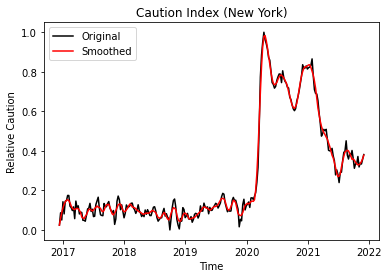

In [762]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
#from matplotlib.dates import DateFormatter
#import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import datetime
from scipy import stats
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.var_model import VAR
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank

%matplotlib inline

def mape(actual, fc): 
    actual, fc = np.array(actual), np.array(fc)
    return np.mean(np.abs((actual - fc) / actual)) * 100

def func_exp(t, tau):
    return np.exp(-t / tau)

df1 = pd.read_csv("C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\gtrend_caution.csv") 
df1.head()
df1['date'] = pd.to_datetime(df1.date)
df1.set_index("date", inplace = True)

fig, ax = plt.subplots()
ax.plot(df1.caution,'k-')
ax.set_xlabel("Time")
ax.set_ylabel("Relative Caution")
ax.set_title("Caution Index (New York)")

# Smoothing
df1['caution_sm'] = savgol_filter(df1.caution, window_length = 11, polyorder = 2)
ax.plot(df1.caution_sm,'r-')
ax.legend(['Original','Smoothed'])
plt.show()

df1['caution'] = df1['caution_sm']

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

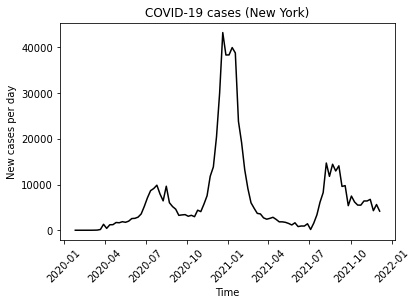

In [764]:
#Read in COVID case numbers

df2 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv') 
df2['submission_date']=pd.to_datetime(df2.submission_date)
df2.set_index('submission_date', inplace = True)
df2 = df2[df2.state=="NY"]
#df2 = df2[df2.state=="CA"]
df2.head()

# Aggregate to weekly
new_cases = df2.new_case.resample('W').mean()

plt.plot(new_cases,'k-')
plt.xlabel('Time')
plt.ylabel('New cases per day')
plt.title('COVID-19 cases (New York)')
plt.xticks(rotation=45)


C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


,temp_C
month_date,
2019-01-20,2.000000
2019-01-27,1.639374
2019-02-03,1.431490
2019-02-10,1.450395
2019-02-17,2.000000
...,...
2022-11-20,9.000000
2022-11-27,9.317951
2022-12-04,8.822310


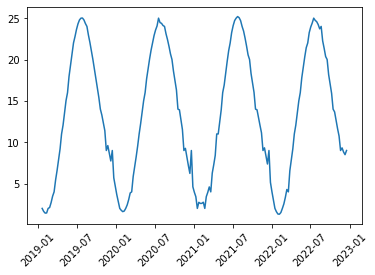

In [765]:
# Repeat average temperature data over several years and interpolate to weeks

df3 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\ny_weather.csv') 
df3['month_date']=pd.to_datetime(df3.month_date)
df3.set_index('month_date', inplace = True)

# Other way
#df3['yyyy'] = pd.to_datetime(df3['month_date']).dt.year
#df3['mm'] = pd.to_datetime(df3['month_date']).dt.month
#df3['dd'] = pd.to_datetime(df3['month_date']).dt.day

#duplicate to multiyear
#df3_copy1 = df3.copy()
#df3_copy1['yyyy'] = df3_copy1['yyyy']-1
#df3_copy1['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy1['yyyy'].astype(str)

#df3_copy2 = df3.copy()
#df3_copy2['yyyy'] = df3_copy2['yyyy']+1
#df3_copy2['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy2['yyyy'].astype(str)

#df3_copy3 = df3.copy()
#df3_copy3['yyyy'] = df3_copy3['yyyy']+2
#df3_copy3['month_date'] = df3['mm'].astype(str) +'/'+ df3['dd'].astype(str) + '/'+ df3_copy3['yyyy'].astype(str)

df3_copy1 = df3.copy()
df3_copy1.index = df3_copy1.index + pd.DateOffset(year=2019)
df3_copy2 = df3.copy()
df3_copy2.index = df3_copy2.index + pd.DateOffset(year=2021)
df3_copy3 = df3.copy()
df3_copy3.index = df3_copy3.index + pd.DateOffset(year=2022)

df3_long = pd.concat([df3_copy1,df3,df3_copy2,df3_copy3],axis=0)
#df3_long['month_date']=pd.to_datetime(df3_long.month_date)
#df3_long.set_index('month_date', inplace = True)

df3_long = df3_long.resample('W').mean().interpolate(method='spline',order=3)

plt.plot(df3_long)
plt.xticks(rotation=45)

df3_long

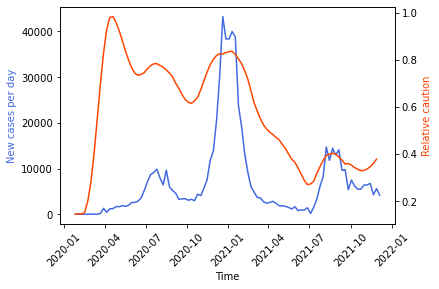

,caution,caution_sm,new_case,temp_C


In [766]:
# Merge the full date range into previous
df_merged = pd.merge(df1,new_cases, how='inner',left_index=True,right_index=True)
df_merged = pd.merge(df_merged,df3_long, how='inner',left_index=True,right_index=True)

# Coplot full range
fig,ax = plt.subplots()
ax.plot(new_cases,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_merged.caution,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

# Subtract baseline "caution" from pre-pandemic and renormalize
df_merged.caution = df_merged.caution-df_merged.caution['2020-01-26':'2020-02-16'].mean()
df_merged.caution = (df_merged.caution-df_merged.caution.min())/(df_merged.caution.max()-df_merged.caution.min())

# Skip initial period of pandemic
df_during = df_merged['2020-04-10':]
# Check for any embedded NaN's that need to be filled
df_during[df_during.caution.isna()==True]

C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


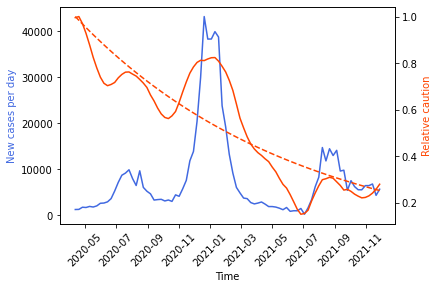

In [767]:
# Coplot 
fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_during.caution,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

np.random.seed(0)
t = np.arange(0,len(df_during.caution))
params, cov = curve_fit(func_exp, t, df_during.caution.values)
tau = params
y_fit = func_exp(t, tau)

df_during.loc[:,'caution2'] = df_during.caution-y_fit

ax2.plot(df_during.index, y_fit, color='orangered',linestyle = '--')

plt.show()

#fig.savefig('Caution_and_new_cases.png',
#            format='png',
#            dpi=100,
#            bbox_inches='tight')

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution2']= (df_during.caution2-min_cau)/(range_cau)
C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())


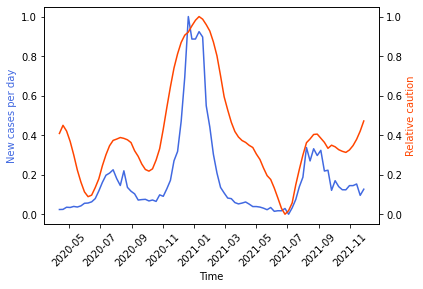

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/3332752693.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)


array([[1.       , 0.7067082],
       [0.7067082, 1.       ]])

In [768]:
# Max-min normalize
min_cau = np.min(df_during.caution2)
range_cau = np.max(df_during.caution2)-np.min(df_during.caution2)
df_during['caution2']= (df_during.caution2-min_cau)/(range_cau)
df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())

fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='royalblue')
ax.set_ylabel('New cases per day',color='royalblue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)
#ax.plot(df_during.new_case.diff(),color='black')

ax2 = ax.twinx()
ax2.plot(df_during.caution2,color='orangered')
ax2.set_ylabel('Relative caution',color='orangered')

plt.show()

epsilon = 0.01  # Prevent -inf
df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)

np.corrcoef(df_during.log_caution, df_during.log_new_case)

In [769]:
print(sm.tsa.stattools.adfuller(df_during.caution2))
print(sm.tsa.stattools.adfuller(df_during.new_case))

# One round of differencing makes stationary
print(sm.tsa.stattools.adfuller(df_during.caution.diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().dropna()))

# Log transform also works
print(sm.tsa.stattools.adfuller(df_during.log_caution))
print(sm.tsa.stattools.adfuller(df_during.log_new_case))


(-2.247838238374185, 0.18934305662127787, 7, 78, {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}, -395.58881850533226)
(-2.7405910878535322, 0.06727374052494661, 5, 80, {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}, -189.9378545363279)
(-2.538742775648872, 0.10633004552325254, 6, 78, {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}, -485.5324484023371)
(-4.528973735862212, 0.00017424691338535327, 6, 78, {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}, -181.34910873341812)
(-3.082702611022382, 0.027860038176761717, 1, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, 9.633450806264307)
(-3.788179462359658, 0.0030305965383054883, 4, 81, {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}, 42.92688085772801)


In [770]:
grangercausalitytests(df_during[['log_caution','log_new_case']],maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6335  , p=0.0043  , df_denom=82, df_num=1
ssr based chi2 test:   chi2=8.9494  , p=0.0028  , df=1
likelihood ratio test: chi2=8.5089  , p=0.0035  , df=1
parameter F test:         F=8.6335  , p=0.0043  , df_denom=82, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0861  , p=0.0015  , df_denom=79, df_num=2
ssr based chi2 test:   chi2=15.0691 , p=0.0005  , df=2
likelihood ratio test: chi2=13.8601 , p=0.0010  , df=2
parameter F test:         F=7.0861  , p=0.0015  , df_denom=79, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3716  , p=0.0021  , df_denom=76, df_num=3
ssr based chi2 test:   chi2=17.5989 , p=0.0005  , df=3
likelihood ratio test: chi2=15.9610 , p=0.0012  , df=3
parameter F test:         F=5.3716  , p=0.0021  , df_denom=76, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2670  , p=0.0037  , df_d

{1: ({'ssr_ftest': (8.633545885637071, 0.004284464554853374, 82.0, 1),
   'ssr_chi2test': (8.949407320477452, 0.0027755962266073856, 1),
   'lrtest': (8.5089386758535, 0.0035340612493616388, 1),
   'params_ftest': (8.633545885637142, 0.00428446455485323, 82.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.086066484083583, 0.0014773099150423071, 79.0, 2),
   'ssr_chi2test': (15.069103409190403, 0.0005343007343452818, 2),
   'lrtest': (13.860069050258858, 0.0009779671033717059, 2),
   'params_ftest': (7.086066484083597, 0.001477309915042292, 79.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.371563589751934, 0.0020830250860398815, 76.0, 3),
   'ssr_chi2test': (17.5989386032662, 0.0005320775305513886, 3),
   'lrtest': (15.960991229451992, 0.0011550585779572268, 3),
   'params_ftest': (5.371563589751955, 0.0020830250860398246, 76.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
         

In [749]:
grangercausalitytests(df_during[['log_new_case','log_caution']],maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1074  , p=0.0817  , df_denom=82, df_num=1
ssr based chi2 test:   chi2=3.2211  , p=0.0727  , df=1
likelihood ratio test: chi2=3.1616  , p=0.0754  , df=1
parameter F test:         F=3.1074  , p=0.0817  , df_denom=82, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8639  , p=0.0102  , df_denom=79, df_num=2
ssr based chi2 test:   chi2=10.3435 , p=0.0057  , df=2
likelihood ratio test: chi2=9.7545  , p=0.0076  , df=2
parameter F test:         F=4.8639  , p=0.0102  , df_denom=79, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6596  , p=0.0542  , df_denom=76, df_num=3
ssr based chi2 test:   chi2=8.7137  , p=0.0334  , df=3
likelihood ratio test: chi2=8.2860  , p=0.0405  , df=3
parameter F test:         F=2.6596  , p=0.0542  , df_denom=76, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1016  , p=0.0893  , df_d

{1: ({'ssr_ftest': (3.1074173325548085, 0.08166235402894213, 82.0, 1),
   'ssr_chi2test': (3.2211033325263254, 0.07269461631338181, 1),
   'lrtest': (3.161570300467247, 0.07539063294282126, 1),
   'params_ftest': (3.1074173325547596, 0.08166235402894452, 82.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.863891163322425, 0.010183916871812616, 79.0, 2),
   'ssr_chi2test': (10.343464752381864, 0.005674729532675084, 2),
   'lrtest': (9.754517183607334, 0.007617869117196181, 2),
   'params_ftest': (4.863891163322467, 0.010183916871812216, 79.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.659599683205894, 0.054155721150439734, 76.0, 3),
   'ssr_chi2test': (8.713688435766677, 0.0333500028717915, 3),
   'lrtest': (8.285975858041695, 0.04045679030884618, 3),
   'params_ftest': (2.659599683205896, 0.05415572115043946, 76.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [771]:
result = coint(df_during.new_case, df_during.caution)
result

(-2.767657818469858,
 0.17619244130039274,
 array([-4.0299263 , -3.40895789, -3.09472294]))

In [772]:
result = coint(df_during.new_case, df_during.caution2)
result

(-3.2752311077814165,
 0.05822154789086073,
 array([-4.0299263 , -3.40895789, -3.09472294]))

Text(0.5, 1.0, 'New case')

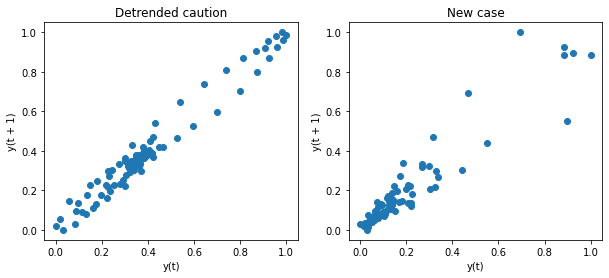

In [773]:
fig_lag, (ax1, ax2) = plt.subplots(1,2,figsize= (10,4))

pd.plotting.lag_plot(df_during.caution2,ax=ax1)
ax1.set_title('Detrended caution')
pd.plotting.lag_plot(df_during.new_case,ax=ax2)
ax2.set_title('New case')

Text(0.5, 1.0, 'Log(new cases)')

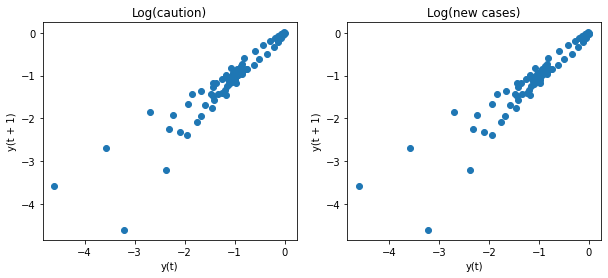

In [698]:
fig_lag_log, (ax1, ax2) = plt.subplots(1,2,figsize= (10,4))

pd.plotting.lag_plot(df_during.log_caution,ax=ax1)
ax1.set_title('Log(caution)')
pd.plotting.lag_plot(df_during.log_caution,ax=ax2)
ax2.set_title('Log(new cases)')

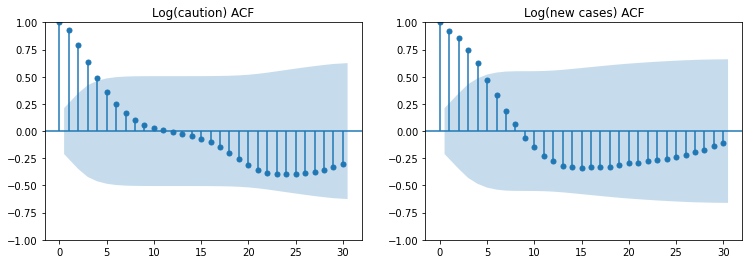

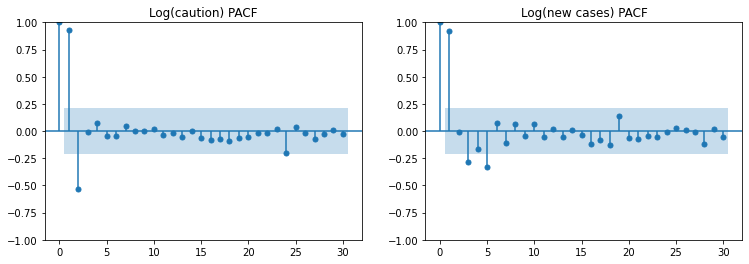

In [774]:
fig_acf, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,4))

plot_acf(df_during.log_caution, lags = 30, ax = ax1)
ax1.set_title('Log(caution) ACF')
plot_acf(df_during.log_new_case, lags = 30, ax = ax2)
ax2.set_title('Log(new cases) ACF')
plt.show()

fig_pacf, (ax1, ax2) = plt.subplots(1,2, figsize=(12.5,4))

plot_pacf(df_during.log_caution, lags = 30, ax = ax1, method='ywm')
ax1.set_title('Log(caution) PACF')
plot_pacf(df_during.log_new_case, lags = 30, ax = ax2, method='ywm')
ax2.set_title('Log(new cases) PACF')
plt.show()

In [775]:
df_sub = df_during[['new_case','caution2']]
train, test = df_sub[0:round(0.8*(len(df_sub.caution2)))], df_sub[round(0.8*(len(df_sub.caution2))):]

rank = select_coint_rank(train, det_order=0, k_ar_diff=4, method='maxeig', signif=0.05)

rank.summary()
# not quite


r_0,r_1,test statistic,critical value
0,1,33.98,14.26
1,2,2.376,3.841


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


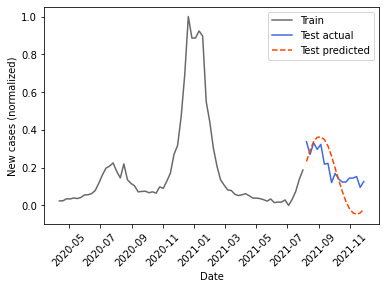

,coef,std err,z,P>|z|,[0.025,0.975]
L1.new_case,0.3559,0.096,3.699,0.000,0.167,0.544
L1.caution2,0.8108,0.441,1.840,0.066,-0.053,1.674
L2.new_case,0.2010,0.104,1.930,0.054,-0.003,0.405
L2.caution2,-0.9078,0.639,-1.420,0.156,-2.161,0.345
L3.new_case,0.1708,0.109,1.572,0.116,-0.042,0.384
L3.caution2,0.0564,0.669,0.084,0.933,-1.256,1.368
L4.new_case,0.4307,0.107,4.024,0.000,0.221,0.640
L4.caution2,0.4354,0.438,0.993,0.321,-0.424,1.295
,coef,std err,z,P>|z|,[0.025,0.975]
L1.new_case,0.0223,0.028,0.809,0.418,-0.032,0.076


In [779]:
model_VECM = VECM(train, coint_rank=1, k_ar_diff=)
vecm_res = model_VECM.fit()

fc_vecm, lower, upper = vecm_res.predict(steps=len(test), alpha=0.05)

plt.plot(train.new_case, color='dimgray')
plt.plot(test.new_case, color='royalblue')
plt.plot(test.index,fc_vecm[:,0], color='orangered',linestyle='--')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('New cases (normalized)')
plt.legend(['Train','Test actual','Test predicted'])
plt.show()

vecm_res.summary()

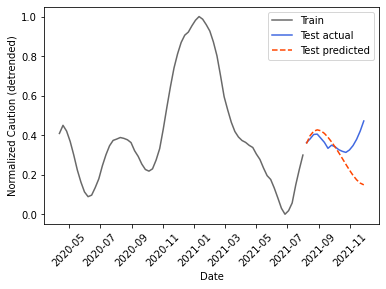

In [780]:
fig,ax = plt.subplots()

ax.plot(train.caution2,color='dimgray')
ax.plot(test.caution2,color='royalblue')
ax.plot(test.index,fc_vecm[:,1],color='orangered',linestyle='--')

ax.set_ylabel('Normalized Caution (detrended)')
ax.set_xlabel('Date')
ax.legend(['Train','Test actual','Test predicted'])

plt.xticks(rotation=45)
plt.show()

In [781]:
# Create date index for next 6 weeks

L=6
i=0
fc_ind = [None]*(L+1)
fc_ind[0]=df_sub.index[-1]
while i<L:
    fc_ind[i+1] = fc_ind[i] + pd.Timedelta(days=7)
    i+=1


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


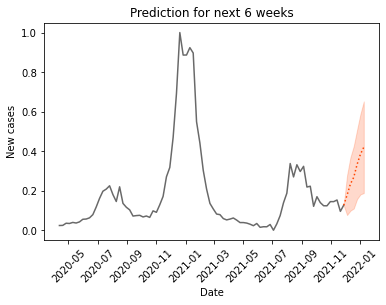

In [782]:
model_VECM = VECM(df_sub, coint_rank=1, k_ar_diff=4, dates=df_sub.index)
vecm_res = model_VECM.fit()

fc_vecm, lower, upper = vecm_res.predict(steps=L, alpha=0.05)

plt.plot(df_sub.new_case,color='dimgray')
plt.plot(fc_ind,np.insert(fc_vecm[:,0],0,df_sub.new_case.values[-1]),color='orangered',linestyle=':')

plt.fill_between(fc_ind,
                 np.insert(lower[:,0],0,df_sub.new_case.values[-1]),
                 np.insert(upper[:,0],0,df_sub.new_case.values[-1]),
                 color='orangered',alpha=0.2)

plt.ylabel('New cases')
plt.xlabel('Date')
plt.title('Prediction for next 6 weeks')

plt.xticks(rotation=45)
plt.show()


In [784]:
err_nc = [None]*(3)
err_nc_naive = [None]*3
err_cau = [None]*(3)
err_cau_naive = [None]*3
fc_weeks = 6
new_case_naive = [None]*fc_weeks
i = 0

for frac_train in np.arange(0.8,0.95, 0.05):
    train, test = df_sub[0:round(frac_train*(len(df_sub.caution2)))], df_sub[round(frac_train*(len(df_sub.caution2))):]
    
    model_VECM = VECM(train, coint_rank=1, k_ar_diff=4)
    vecm_res = model_VECM.fit()

    fc_vecm = vecm_res.predict(steps=fc_weeks)
    
    err_nc[i] = mape(test.new_case.values[:fc_weeks], fc_vecm[:,0])
    new_case_naive[0:fc_weeks] = np.repeat(test.new_case.values[0],fc_weeks)
    err_nc_naive[i] = mape(test.new_case.values[:fc_weeks],new_case_naive)
    
    err_cau[i] = mape(test.caution2.values[:fc_weeks], fc_vecm[:,1])
    new_case_naive[0:fc_weeks] = np.repeat(test.caution2.values[0],fc_weeks)
    err_cau_naive[i] = mape(test.caution2.values[:fc_weeks],new_case_naive)
    
    i+=1
    
print('Mean VECM new case',str(fc_weeks),'week MAPE error:', np.mean(err_nc))
print('Mean Naive new case',str(fc_weeks),'week MAPE error:', np.mean(err_nc_naive))

print('Mean VECM caution',str(fc_weeks),'week MAPE error:', np.mean(err_cau))
print('Mean Naive caution',str(fc_weeks),'week MAPE error:', np.mean(err_cau_naive))


Mean VECM new case 6 week MAPE error: 23.312231044108568
Mean Naive new case 6 week MAPE error: 39.533533351679374
Mean VECM caution 6 week MAPE error: 13.493942012327643
Mean Naive caution 6 week MAPE error: 6.739305009138303


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=33.478, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=36.054, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=54.996, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=34.483, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=130.919, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=38.369, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=30.098, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=47.818, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=61.794, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.587, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=33.327, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=94.299, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=26.693, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=144.661, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=38.860, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             : 

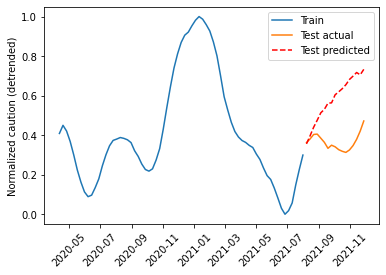

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 -13.219
Date:                Thu, 09 Dec 2021   AIC                             40.439
Time:                        17:03:37   BIC                             56.077
Sample:                             0   HQIC                            46.643
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0817      0.185      0.442      0.658      -0.280       0.444
ar.L1          0.7206      9.394      0.077      0.939     -17.692      19.133
ar.L2          0.3897     10.902      0.036      0.971     -20.979      21.758
ar.L3         -0.2302      1.232     -0.187      0.852      -2.645       2.184
ar.L4          0.0146      1.143      0.013      0.990      -2.225       2.254
ma.L1          0.4371      9.401      0.046      0.963     -17.989      18.864
sigma2         0.0781      0.016      4.849      0.000       0.047       0.110
===================================================================================
Ljung-Box (L1) (Q):                   2.81   Jarque-Bera (JB):               474.27
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [789]:
df_log = df_during[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_during.log_caution)))], df_log[round(0.8*(len(df_during.log_caution))):]

model = auto_arima(df_during.log_caution,start_p=2, d=0, q=0, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1, method='nm')

model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.log_new_case.values,(-1,1)), n_periods=len(test))

forecast = pd.DataFrame(forecast,index = test.index,columns=['log_caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(np.exp(train.log_caution)-epsilon)
plt.plot(np.exp(forecast.log_caution)-epsilon)
plt.plot(np.exp(forecast.log_caution_pred)-epsilon, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Normalized caution (detrended)')
plt.legend(['Train','Test actual','Test predicted'])
plt.show()

model.summary()


In [788]:
err = [None]*(3)
err_naive = [None]*3
fc_weeks = 6
new_case_naive = [None]*fc_weeks
i = 0

for frac_train in np.arange(0.8,0.95, 0.05):    
    df_log = df_during[['log_new_case','log_caution']]
    train, test = df_log[0:round(frac_train*(len(df_during.log_caution)))], df_log[round(frac_train*(len(df_during.log_caution))):]

    model = auto_arima(df_during.log_caution,start_p=2, d=0, q=0, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1, method='nm')
    res = model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))

    fc = model.predict(exogenous=np.reshape(test.log_new_case.values[:fc_weeks],(-1,1)), n_periods=fc_weeks)
    
    err[i] = mape(np.exp(test.log_caution.values[:fc_weeks])-epsilon, np.exp(fc)-epsilon)
    new_case_naive[0:fc_weeks] = np.repeat(test.log_caution.values[0],fc_weeks)
    err_naive[i] = mape(np.exp(test.log_caution.values[:fc_weeks])-epsilon, np.exp(new_case_naive)-epsilon)
    i+=1
    
print('Mean ARMAX',str(fc_weeks),'week error:', np.mean(err))
print('Mean Naive',str(fc_weeks),'week error:', np.mean(err_naive))

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3.314, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=5.929, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=54.993, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=5.290, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7.308, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5.772, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5.273, Time=0.35 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=46.603, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=61.788, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.587, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9.253, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=94.299, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5.767, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=144.661, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=7.060, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6.468,

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3.314, Time=0.18 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=5.929, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=54.993, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=5.290, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7.308, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5.772, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5.273, Time=0.38 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=46.603, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=61.788, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.587, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9.253, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=94.299, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5.767, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=144.661, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=7.060, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6.468,

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3.314, Time=0.17 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=5.929, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=54.993, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=5.290, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7.308, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5.772, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5.273, Time=0.29 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=46.603, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=61.788, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33.587, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9.253, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=94.299, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5.767, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=144.661, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=7.060, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6.468,

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


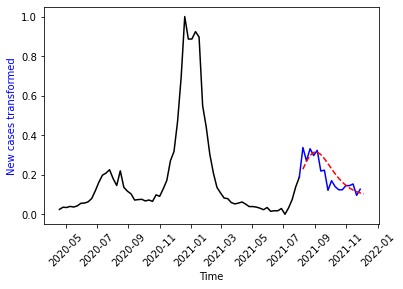

Dep. Variable:,"['log_new_case', 'log_caution']",No. Observations:,68
Model:,VAR(2),Log Likelihood,3.553
,+ intercept,AIC,18.894
Date:,"Thu, 09 Dec 2021",BIC,47.748
Time:,16:03:34,HQIC,30.327
Sample:,04-19-2020,,
,- 08-01-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.37, 1.90",Jarque-Bera (JB):,"3.91, 109.90"
Prob(Q):,"0.54, 0.17",Prob(JB):,"0.14, 0.00"
Heteroskedasticity (H):,"1.79, 5.89",Skew:,"0.38, -0.27"


In [717]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_log = df_during2[['log_new_case','log_caution']]
train, test = df_log[0:round(0.8*(len(df_log.log_caution)))], df_during[round(0.8*(len(df_log.log_caution))):]
temp_train, temp_test = df_during2.temp_C[0:round(0.8*(len(df_log.log_caution)))], df_during2.temp_C[round(0.8*(len(df_log.log_caution))):]

#model2 = sm.tsa.VARMAX(endog=train, exog=temp_train, order=(2,0), trend='c')
# Temperature coefficient wasn't significant for FL, seemed to overweight winter surge of 2020 for NY
model2 = sm.tsa.VARMAX(endog=train, order = (2,0), trend='c')
model2_fit = model2.fit(maxiter=5000, disp=True)

# Only can forecast from end of sample
fc = model2_fit.forecast(steps=len(test.log_new_case))

fig,ax = plt.subplots()

ax.plot(np.exp(train.log_new_case)-epsilon,color='black')

ax.plot(np.exp(test.log_new_case)-epsilon,color='blue')
ax.set_ylabel('New cases transformed',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(np.exp(fc.log_new_case)-epsilon,color='red',linestyle='--')
plt.show()

model2_fit.summary()

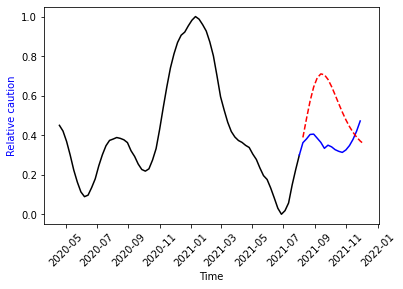

In [718]:
fig,ax = plt.subplots()

ax.plot(np.exp(train.log_caution)-epsilon,color='black')

ax.plot(np.exp(test.log_caution)-epsilon,color='blue')
ax.set_ylabel('Relative caution',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(np.exp(fc.log_caution)-epsilon,color='red',linestyle='--')
plt.show()

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/1299464790.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case_sta'] = df_during.new_case.diff()


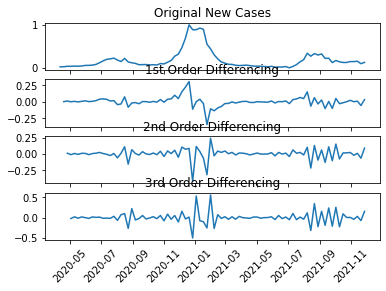

In [711]:
# Make stationary with differencing

fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.new_case); axes[0].set_title('Original New Cases')

# 1st Differencing
axes[1].plot(df_during.new_case.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.new_case.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.new_case.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.new_case.diff().dropna())
result

df_during['new_case_sta'] = df_during.new_case.diff()

C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/2792412098.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution_sta'] = df_during.caution.diff()


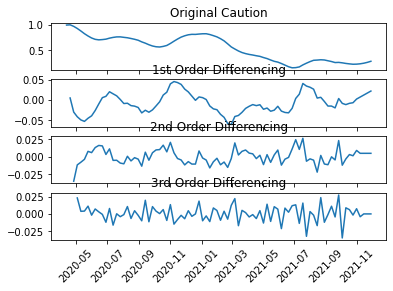

In [712]:
fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.caution); axes[0].set_title('Original Caution')

# 1st Differencing
axes[1].plot(df_during.caution.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.caution.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.caution.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.caution.diff().dropna())
result

df_during['caution_sta'] = df_during.caution.diff()
df_during2 = df_during.dropna()

In [713]:
grangercausalitytests(df_during2[['caution_sta','new_case_sta']],maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4225  , p=0.5175  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=0.4381  , p=0.5080  , df=1
likelihood ratio test: chi2=0.4370  , p=0.5086  , df=1
parameter F test:         F=0.4225  , p=0.5175  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3098  , p=0.2757  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=2.7876  , p=0.2481  , df=2
likelihood ratio test: chi2=2.7418  , p=0.2539  , df=2
parameter F test:         F=1.3098  , p=0.2757  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0391  , p=0.1156  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=6.6883  , p=0.0825  , df=3
likelihood ratio test: chi2=6.4295  , p=0.0925  , df=3
parameter F test:         F=2.0391  , p=0.1156  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8690  , p=0.1252  , df_d

{1: ({'ssr_ftest': (0.4225004003267969, 0.51753128860559, 81.0, 1),
   'ssr_chi2test': (0.43814856330186347, 0.5080174212688636, 1),
   'lrtest': (0.4370098180693276, 0.508569230952863, 1),
   'params_ftest': (0.42250040032681213, 0.5175312886055854, 81.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.3098147168448255, 0.27573912851692073, 78.0, 2),
   'ssr_chi2test': (2.7875543973877055, 0.2481362722886611, 2),
   'lrtest': (2.741766766199362, 0.253882584878209, 2),
   'params_ftest': (1.3098147168448881, 0.2757391285169031, 78.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.0391152646303996, 0.11559888103969457, 75.0, 3),
   'ssr_chi2test': (6.68829806798771, 0.0825250702044514, 3),
   'lrtest': (6.429513913972187, 0.09248413623854314, 3),
   'params_ftest': (2.039115264630393, 0.11559888103969593, 75.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1

In [714]:
grangercausalitytests(df_during2[['new_case_sta','caution_sta']],maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7028  , p=0.0042  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=9.0252  , p=0.0027  , df=1
likelihood ratio test: chi2=8.5725  , p=0.0034  , df=1
parameter F test:         F=8.7028  , p=0.0042  , df_denom=81, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5605  , p=0.0331  , df_denom=78, df_num=2
ssr based chi2 test:   chi2=7.5774  , p=0.0226  , df=2
likelihood ratio test: chi2=7.2512  , p=0.0266  , df=2
parameter F test:         F=3.5605  , p=0.0331  , df_denom=78, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5559  , p=0.0616  , df_denom=75, df_num=3
ssr based chi2 test:   chi2=8.3835  , p=0.0387  , df=3
likelihood ratio test: chi2=7.9820  , p=0.0464  , df=3
parameter F test:         F=2.5559  , p=0.0616  , df_denom=75, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6751  , p=0.1651  , df_d

{1: ({'ssr_ftest': (8.702838742990414, 0.004152537666592188, 81.0, 1),
   'ssr_chi2test': (9.025166103841912, 0.0026628772720157126, 1),
   'lrtest': (8.572473921530332, 0.003412831176503399, 1),
   'params_ftest': (8.70283874299042, 0.0041525376665921656, 81.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.5604559418391437, 0.03313409193408202, 78.0, 2),
   'ssr_chi2test': (7.577380594170486, 0.022625214764553515, 2),
   'lrtest': (7.251204676537554, 0.02663305039852897, 2),
   'params_ftest': (3.5604559418391633, 0.03313409193408139, 78.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.5559305104833516, 0.061577389736095174, 75.0, 3),
   'ssr_chi2test': (8.383452074385394, 0.03871728408255927, 3),
   'lrtest': (7.982039990467911, 0.046384346884436545, 3),
   'params_ftest': (2.5559305104833387, 0.0615773897360961, 75.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

In [719]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_sta = df_during2[['new_case_sta','caution_sta']].dropna()
train, test = df_sta[0:round(0.8*(len(df_sta.caution_sta)))], df_sta[round(0.8*(len(df_sta.caution_sta))):]
print(train.shape, test.shape)

model = auto_arima(df_sta.caution_sta, start_p=2, d=1, start_q=1, exogenous=np.reshape(df_sta.new_case_sta.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
fit_sta = model.fit(train.caution_sta, exogenous=np.reshape(train.new_case_sta.values,(-1,1)))

fit_sta.summary()

(68, 2) (17, 2)


C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-535.850, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-528.690, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-542.643, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-525.650, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-533.703, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-538.265, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-536.107, Time=0.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-542.731, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-530.271, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-546.072, Time=0.45 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-539.733, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-537.923, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-545.197, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-529.719, Time=0.86 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-537.614, Time=0.48 sec
 ARIMA(1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 223.960
Date:                Thu, 09 Dec 2021   AIC                           -431.921
Time:                        16:04:03   BIC                           -414.283
Sample:                             0   HQIC                          -424.942
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.145      0.885      -0.003       0.002
x1            -0.0087      0.010     -0.871      0.384      -0.028       0.011
ar.L1          0.2110      0.350      0.603      0.546      -0.474       0.896
ar.L2          0.5073      0.217      2.342      0.019       0.083       0.932
ar.L3          0.0210      0.172      0.122      0.903      -0.317       0.359
ar.L4         -0.4458      0.155     -2.878      0.004      -0.749      -0.142
ma.L1          0.2459      0.401      0.614      0.539      -0.539       1.031
sigma2      7.201e-05   1.62e-05      4.432      0.000    4.02e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.60   Prob(JB):                         0.75
Heteroskedasticity (H):               1.63   Skew:                            -0.21
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [720]:
lag_order = 1  # based on model fit
forecast_input = train.caution_sta.values[-lag_order:]
fc = fit_sta.predict(exogenous=np.reshape(test.new_case_sta.values,(-1,1)), n_periods=len(test))
df_forecast = pd.DataFrame(fc,index=df_sta.index[-len(test):], columns = ['caution_sta_fc'])

df_fc = df_forecast.copy()
df_check = pd.DataFrame()

# De-difference
df_fc['caution_fc'] = df_during2['caution'].iloc[len(train)-1] + df_fc['caution_sta_fc'].cumsum()

# Check   
df_check['caution_check'] = df_during2['caution'].iloc[len(train)-1] + test["caution_sta"].cumsum()
df_check['caution'] = df_during2['caution'].iloc[len(train):]

test['caution_fc']=df_fc['caution_fc']



C:\Users\Ping\AppData\Local\Temp/ipykernel_1420/835576867.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=df_fc['caution_fc']


In [721]:
df_check

,caution_check,caution
2021-08-08,0.298378,0.298378
2021-08-15,0.302623,0.302623
2021-08-22,0.308790,0.308790
2021-08-29,0.304655,0.304655
2021-09-05,0.289218,0.289218
2021-09-12,0.273724,0.273724
2021-09-19,0.253743,0.253743
2021-09-26,0.256925,0.256925
2021-10-03,0.248110,0.248110
2021-10-10,0.236227,0.236227


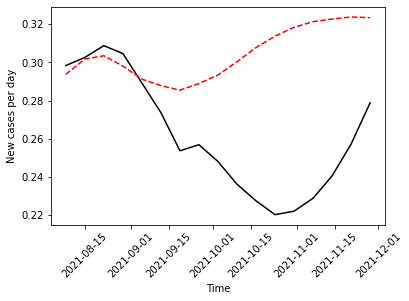

In [722]:
fig,ax = plt.subplots()

ax.plot(df_during2.caution[round(0.8*(len(df_sta.caution_sta))):],color='black')
ax.set_ylabel('New cases per day',color='black')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(test.caution_fc,color='red',linestyle='--')
plt.show()